# Aujourd'hui on roule sur les mecs de l'ENS


https://challengedata.ens.fr/en/challenge/39/prediction_of_transaction_claims_status.html

# Imports des librairies de bases

On ajoutera celles qui manquent au fur et à mesure de nos besoins

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import os, gc

# Définition de la seed pour le random

Très important pour qu'on voit les mêmes choses entre nos deux ordis

In [2]:
RANDOM_SEED = 42;
np.random.seed(RANDOM_SEED)

# Définition des paramètres pour Matplot

Rien de bien intéréssant

In [3]:
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Set des variables globales

Attention, je n'utilise les variables globales pour la gestion des fichiers. Sinon, c'est mort

In [4]:
# Where to save the figures
PROJECT_ROOT_DIR = ".."
DATA_PROCESSED = os.path.join(PROJECT_ROOT_DIR, "data_processed")

# Fonction pour load les libraires

En vrai, on a juste besoin de pd.read_csv, mais c'était pour faire joli

In [5]:
def load_data(file,data_path=DATA_PROCESSED, sep=';'):
    csv_path = os.path.join(data_path, file)
    return pd.read_csv(csv_path, sep=';')

# On load les jeux de données

In [6]:
TX_data = load_data(file = "train.csv");
TX_data.shape

(100000, 34)

In [7]:
TX_data.head()

,SHIPPING_MODE,SHIPPING_PRICE,CARD_PAYMENT,COUPON_PAYMENT,RSP_PAYMENT,WALLET_PAYMENT,PRICECLUB_STATUS,REGISTRATION_DATE,PURCHASE_COUNT,BUYER_BIRTHDAY_DATE,...,SELLER_DEPARTMENT_PIB,CAC_POINTS,CAC_VAR,IS_HOLIDAYS,IS_SALES,Mean_Claims_Sells_ID,STD_Claims_Sells_ID,Count_PRODUCT_TYPE,Mean_Claims_PRODUCT_TYPE,STD_Claims_PRODUCT_TYPE
0,NORMAL,0,1,0,1,0,0,2015,0,1992.0,...,20885,5122,5,0,0,0.571429,0.507093,19285.0,0.505522,0.499982
1,NORMAL,0,1,0,0,0,0,2013,0,1952.0,...,20589,5085,0,1,1,0.333333,0.472657,19285.0,0.505522,0.499982
2,NORMAL,0,0,0,0,1,4,2013,3,1991.0,...,-99999,5283,0,0,0,0.607143,0.488575,2583.0,0.573364,0.494684
3,RECOMMANDE,0,1,0,0,0,0,2007,5,1955.0,...,19908,5283,0,0,0,0.707113,0.456042,362.0,0.533149,0.499590
4,RECOMMANDE,0,1,0,1,0,4,2010,1,1984.0,...,-99999,5329,5,0,0,0.628676,0.483239,222.0,0.653153,0.477042


In [8]:
TX_data.drop(['CARD_PAYMENT','COUPON_PAYMENT','RSP_PAYMENT','WALLET_PAYMENT'], axis = 1, inplace = True)

In [9]:
TX_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 30 columns):
SHIPPING_MODE                100000 non-null object
SHIPPING_PRICE               100000 non-null int64
PRICECLUB_STATUS             100000 non-null int64
REGISTRATION_DATE            100000 non-null int64
PURCHASE_COUNT               100000 non-null int64
BUYER_BIRTHDAY_DATE          100000 non-null float64
BUYING_DATE                  100000 non-null int64
SELLER_SCORE_COUNT           100000 non-null int64
SELLER_SCORE_AVERAGE         100000 non-null float64
SELLER_COUNTRY               100000 non-null object
PRODUCT_TYPE                 100000 non-null object
PRODUCT_FAMILY               100000 non-null object
ITEM_PRICE                   100000 non-null int64
CLAIM_TYPE                   100000 non-null object
WARRANTY_COV_RATE            100000 non-null float64
SELLER_COUNTRY_PIB           100000 non-null int64
SELLER_COUNTRY_DISTANCE      100000 non-null int64
BUYER_DEPART

In [10]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(TX_data, 
                                       test_size=0.3, 
                                       random_state=RANDOM_SEED, 
                                       stratify=TX_data["CLAIM_TYPE"]
                                      )
del TX_data;

# Jointure entre les X et Y

In [11]:
def datapreprocess(data):
    data=data.apply(pd.to_numeric, errors='ignore')
    
    # Y and X
    try :
        Y=data["CLAIM_TYPE"]
        X=data.drop("CLAIM_TYPE", axis=1,inplace=False)
    except:
        Y=0
        X=data
    # Exclude Objets
    X=X.select_dtypes(exclude=['object'])
    
    # Work on fare
    from sklearn.preprocessing import Imputer
    imp = Imputer(missing_values='NaN',strategy='median', axis=1)
    X=pd.DataFrame(imp.fit_transform(X),columns=X.columns.values)
 
    return X, Y

In [12]:
X_train, Y_train = datapreprocess(train_set)
X_test, Y_test = datapreprocess(test_set)

#del TX_data;
gc.collect()

339

In [13]:
def multiclass_roc_auc_score(truth, pred):
    from sklearn.metrics import roc_auc_score
    from sklearn.preprocessing import LabelBinarizer
    lb = LabelBinarizer()
    lb.fit(truth)
    return roc_auc_score(lb.transform(truth), lb.transform(pred), average="weighted")

In [14]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

# MODEL!

In [15]:
from sklearn.model_selection import GridSearchCV

## Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier

### Random Forest Solo

In [33]:
params_RF={
            'bootstrap':True, 
            'class_weight':'balanced',
            'criterion':'gini', 
            'max_depth':5, 
            'max_features':'auto',
            'max_leaf_nodes':20, 
            'min_impurity_decrease':0.0,
            'min_impurity_split':None, 
            'min_samples_leaf':10,
            'min_samples_split':2, 
            'min_weight_fraction_leaf':0.0,
            'n_estimators':2000, 
            'n_jobs':-1, 
            'oob_score':False, 
            'random_state':RANDOM_SEED,
            'verbose':0, 
            'warm_start':False
}

In [34]:
rnd_clf = RandomForestClassifier(**params_RF)

In [35]:
rnd_clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=20, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=2000, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [36]:
feature_importance=pd.DataFrame({'Name':X_train.columns, 'Importance':rnd_clf.feature_importances_})
feature_importance.sort_values(by='Importance', ascending=False)

,Importance,Name
7,0.143928,SELLER_SCORE_AVERAGE
6,0.127846,SELLER_SCORE_COUNT
20,0.127756,Mean_Claims_Sells_ID
10,0.089548,SELLER_COUNTRY_PIB
21,0.083117,STD_Claims_Sells_ID
23,0.079297,Mean_Claims_PRODUCT_TYPE
22,0.072134,Count_PRODUCT_TYPE
8,0.062454,ITEM_PRICE
24,0.042658,STD_Claims_PRODUCT_TYPE
11,0.042037,SELLER_COUNTRY_DISTANCE


In [37]:
y_pred_rf_train = rnd_clf.predict(X_train)
y_pred_rf = rnd_clf.predict(X_test)

In [38]:
train_mAUC = multiclass_roc_auc_score(Y_train, y_pred_rf_train)
test_mAUC = multiclass_roc_auc_score(Y_test, y_pred_rf)

In [39]:
print("Performance sur le train : {}".format(train_mAUC))
print("Performance sur le test : {}".format(test_mAUC))
print("Ratio entre les deux : {} ".format(test_mAUC/train_mAUC))

Performance sur le train : 0.6074584754225644
Performance sur le test : 0.6042994528436461
Ratio entre les deux : 0.9947996073695066 


Avec toutes les variables : 0.5870183555383386

Sans les vars : 0.5888784634298747 (+0.00186)

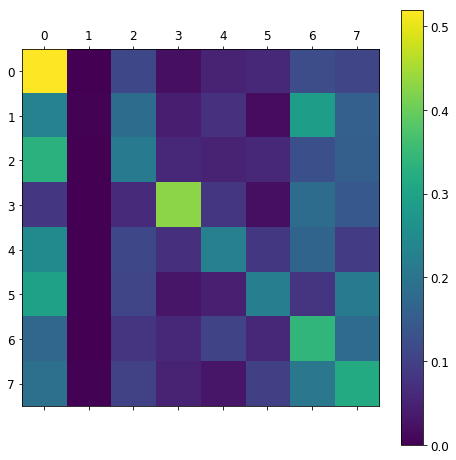

In [24]:
conf_mx = confusion_matrix(Y_test, y_pred_rf)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
plot_confusion_matrix(norm_conf_mx)

### Random Forest Grid Search

In [25]:
params_RF_CV = {
        'max_depth':list(range(4, 6)), 
        'max_leaf_nodes':list(range(10, 30, 10)), 
        'min_samples_leaf':list(range(10, 30, 10)),
        'min_samples_split':list(range(2, 4)), 
        #'oob_score':[False,True] 
}

params_RF={
        'bootstrap':True, 
        'class_weight':'balanced',
        'criterion':'gini', 
        'max_features':'auto',
        'n_estimators':1000, 
        #'min_impurity_decrease':0.0,
        #'min_impurity_split':None,
        #'min_weight_fraction_leaf':0.0,         
        'random_state':RANDOM_SEED,
        #'verbose':0,
        'n_jobs':-1,
        #'warm_start':False
}

In [26]:
rf_gs_cv = GridSearchCV(
                        RandomForestClassifier(**params_RF), 
                        params_RF_CV,
                        scoring="f1_weighted",
                        n_jobs=-1, 
                        verbose=1
)

In [27]:
rf_gs_cv.fit(X_train, Y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 14.5min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [4, 5], 'max_leaf_nodes': [10, 20], 'min_samples_leaf': [10, 20], 'min_samples_split': [2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=1)

In [28]:
rf_gs_cv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=20, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [29]:
y_pred_cv_rf_train = rf_gs_cv.best_estimator_.predict(X_train)
y_pred_cv_rf = rf_gs_cv.best_estimator_.predict(X_test)

In [30]:
train_mAUC = multiclass_roc_auc_score(Y_train, y_pred_cv_rf_train)
test_mAUC = multiclass_roc_auc_score(Y_test, y_pred_cv_rf)

In [31]:
print("Performance sur le train : {}".format(train_mAUC))
print("Performance sur le test : {}".format(test_mAUC))
print("Ratio entre les deux : {} ".format(test_mAUC/train_mAUC))

Performance sur le train : 0.6070786338084725
Performance sur le test : 0.603800692011254
Ratio entre les deux : 0.9946004658792642 


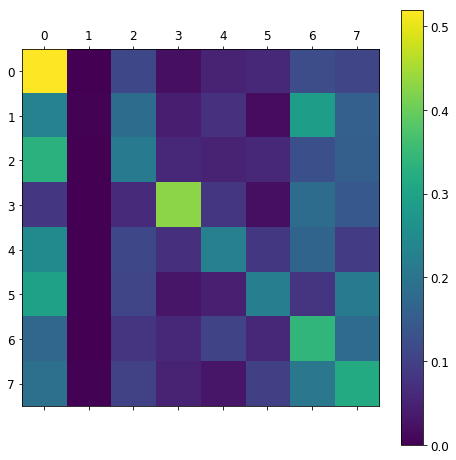

In [32]:
conf_mx = confusion_matrix(Y_test, y_pred_cv_rf)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
plot_confusion_matrix(norm_conf_mx)

In [ ]:
#RESULTS["CLAIM_TYPE"] = pd.DataFrame(clf.predict(TEST_DATA), columns=["Result"])

In [ ]:
#filename = DATA_PROCESSED+"/submission_2.csv"

#RESULTS.to_csv(filename, index=False, sep=";")